# TFT + Spatial Adapter Integration Demo

This notebook demonstrates how to integrate a pretrained TFT model into the Spatial Adapter framework using the PretrainedTrendModel wrapper.

The key insight is that we can use any pretrained model as the backbone f_θ in the spatial adapter equation:
Y(t,s) = g(f_θ(x(t,s)) + Φ(s)^T η(t)) + ε

In [1]:
# Import required libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Tuple, Dict, Any
import time

# Darts imports for TFT
from darts import TimeSeries
from darts.models import TFTModel
import pytorch_lightning as pl

# Local imports
from geospatial_neural_adapter import (
    SpatialNeuralAdapter,
    SpatialBasisLearner,
    compute_metrics,
)
from geospatial_neural_adapter.models.pretrained_trend_model import (
    PretrainedTrendModel,
    create_pretrained_trend_model,
)
from geospatial_neural_adapter.models.spatial_adapter import (
    SpatialAdapter,
    create_spatial_adapter,
)
from geospatial_neural_adapter.data.generators import generate_time_synthetic_data
from geospatial_neural_adapter.data.preprocessing import prepare_all_with_scaling, denormalize_predictions
from geospatial_neural_adapter.models.wrapper_examples.tft_wrapper import TFTWrapper

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")

/home/wangxc17/miniconda/envs/geospatial-neural-adapter/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/wangxc17/miniconda/envs/geospatial-neural-adapter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded spatial_utils from: /home/wangxc17/work/TFTModel-use/geospatial-neural-adapter-dev/geospatial_neural_adapter/cpp_extensions/spatial_utils.so
✅ All imports successful!


## 1. Data Generation

We'll use the same synthetic data generator to create a consistent dataset.

In [2]:
# Generate synthetic temporal data with meaningful correlations
print("Generating correlated temporal synthetic data...")

n_locations = 50
n_time_steps = 200
locations = np.linspace(-5, 5, n_locations)
noise_std = 0.1
eigenvalue = 2.0

cat_features, cont_features, targets = generate_time_synthetic_data(
    locs=locations,
    n_time_steps=n_time_steps,
    noise_std=noise_std,
    eigenvalue=eigenvalue,
    eta_rho=0.8,
    f_rho=0.6,
    global_mean=50.0,
    feature_noise_std=0.1,
    non_linear_strength=0.2,
    seed=42
)

print(f"Data shapes: {cont_features.shape}, {targets.shape}")
print(f"Original targets - Mean: {targets.mean():.2f}, Std: {targets.std():.2f}")
print(f"Original targets - Range: {targets.min():.2f} to {targets.max():.2f}")

Generating correlated temporal synthetic data...
Data shapes: (200, 50, 3), (200, 50)
Original targets - Mean: 50.94, Std: 1.28
Original targets - Range: 48.55 to 61.51


## 2. Data Preprocessing

In [3]:
# Prepare datasets with automatic scaling
print("Preparing datasets with automatic scaling...")

train_dataset, val_dataset, test_dataset, preprocessor = prepare_all_with_scaling(
    cat_features=cat_features,
    cont_features=cont_features,
    targets=targets,
    train_ratio=0.7,
    val_ratio=0.15,
    feature_scaler_type="standard",
    target_scaler_type="standard",
    fit_on_train_only=True
)

train_cat, train_cont, train_targets = train_dataset.tensors
val_cat, val_cont, val_targets = val_dataset.tensors
test_cat, test_cont, test_targets = test_dataset.tensors

print(f"Dataset sizes: {len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}")

# Get data dimensions
T, N, F = cont_features.shape
print(f"Original data shape: {cont_features.shape}")
print(f"Number of locations: {N}")
print(f"Number of features: {F}")

Preparing datasets with automatic scaling...
Dataset sizes: 140, 30, 30
Original data shape: (200, 50, 3)
Number of locations: 50
Number of features: 3


## 3. Create and Train TFT Model

We'll create a TFT model and train it on our data. In practice, you might load a pretrained model.

In [4]:
# Prepare data for TFT model
print("Preparing data for TFT model...")

# Use scaled data from preprocessing
train_cont_np = train_cont.numpy().astype(np.float32)
train_targets_np = train_targets.numpy().astype(np.float32)
val_cont_np = val_cont.numpy().astype(np.float32)
val_targets_np = val_targets.numpy().astype(np.float32)
test_cont_np = test_cont.numpy().astype(np.float32)
test_targets_np = test_targets.numpy().astype(np.float32)

# Combine all scaled data for TFT
cont_np = np.concatenate([train_cont_np, val_cont_np, test_cont_np], axis=0)
targets_np = np.concatenate([train_targets_np, val_targets_np, test_targets_np], axis=0)
T_full, N, p = cont_np.shape

print(f"Full data shape: T={T_full}, N={N}, p={p}")
print(f"Using SCALED data (mean={targets_np.mean():.4f}, std={targets_np.std():.4f})")

# Create time index
time_index = pd.date_range("2020-01-01", periods=T_full, freq="D")

# Create multivariate time series
target_df = pd.DataFrame(targets_np, index=time_index, 
                        columns=[f"loc_{i}" for i in range(N)])

# Create covariates with spatial information
locations_expanded = np.tile(locations, (T_full, 1))
cov_full = np.concatenate([cont_np.reshape(T_full, -1), locations_expanded], axis=1).astype(np.float32)

covariate_df = pd.DataFrame(cov_full, index=time_index,
                           columns=[f"cov_{j}_loc_{i}" for i in range(N) for j in range(p)] + 
                                   [f"spatial_loc_{i}" for i in range(N)])

# Create TimeSeries objects
target_ts = TimeSeries.from_dataframe(target_df, fill_missing_dates=True)
covariate_ts = TimeSeries.from_dataframe(covariate_df, fill_missing_dates=True)

print(f"Target TimeSeries shape: {target_ts.values().shape}")
print(f"Covariate TimeSeries shape: {covariate_ts.values().shape}")

Preparing data for TFT model...
Full data shape: T=200, N=50, p=3
Using SCALED data (mean=0.3057, std=1.2972)
Target TimeSeries shape: (200, 50)
Covariate TimeSeries shape: (200, 200)


In [5]:
# TFT model configuration (lighter for demo)
tft_config = {
    "input_chunk_length": min(32, T_full // 8),
    "output_chunk_length": 1,
    "n_epochs": 20,  # Reduced for demo
    "hidden_size": 32,
    "num_attention_heads": 2,
    "dropout": 0.1,
    "random_state": 42,
    "force_reset": True,
    "add_relative_index": True,
    "use_static_covariates": False,
}

print("TFT Configuration:")
for key, value in tft_config.items():
    print(f"  {key}: {value}")

# Create and train TFT model
print("Creating and training TFT model...")

training_cutoff = int(0.8 * T_full)
print(f"Training cutoff: {training_cutoff}")

tft_model = TFTModel(
    input_chunk_length=tft_config["input_chunk_length"],
    output_chunk_length=tft_config["output_chunk_length"],
    n_epochs=tft_config["n_epochs"],
    hidden_size=tft_config["hidden_size"],
    num_attention_heads=tft_config["num_attention_heads"],
    dropout=tft_config["dropout"],
    random_state=tft_config["random_state"],
    force_reset=tft_config["force_reset"],
    add_relative_index=tft_config["add_relative_index"],
    use_static_covariates=tft_config["use_static_covariates"],
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": -1,
        "enable_progress_bar": True,
        "enable_model_summary": False,
        "enable_checkpointing": False,
        "max_epochs": tft_config["n_epochs"],
    },
)

# Train TFT model
start_time = time.time()
tft_model.fit(
    target_ts[:training_cutoff], 
    past_covariates=covariate_ts[:training_cutoff],
    verbose=True
)
tft_training_time = time.time() - start_time
print(f"TFT training completed in {tft_training_time:.2f}s")

# Save the trained TFT model
tft_model_path = "tft_spatial_adapter_model.pth"
print(f"Saving TFT model to {tft_model_path}")
tft_model.save(tft_model_path)

TFT Configuration:
  input_chunk_length: 25
  output_chunk_length: 1
  n_epochs: 20
  hidden_size: 32
  num_attention_heads: 2
  dropout: 0.1
  random_state: 42
  force_reset: True
  add_relative_index: True
  use_static_covariates: False
Creating and training TFT model...
Training cutoff: 160


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | 

Epoch 19: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s, train_loss=3.920]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s, train_loss=3.920]
TFT training completed in 35.65s
Saving TFT model to tft_spatial_adapter_model.pth


## 4. Create TFT Wrapper for Spatial Adapter

Now we'll wrap the trained TFT model using the dedicated `TFTWrapper` from the library, which provides the necessary interface for integrating TFT models into the spatial adapter framework.

The key improvement is that the `TFTWrapper` handles the conversion between tensor formats and TimeSeries formats required by darts, and provides the `parameters()` method needed by `PretrainedTrendModel`.

In [6]:
# Create TFT wrapper for spatial adapter
print("Creating TFT wrapper for spatial adapter...")

# Use the dedicated TFT wrapper from the library

# Create TFT wrapper using the dedicated module
tft_wrapper = TFTWrapper(
    tft_model=tft_model,
    num_locations=N,
    num_features=F
)

# Create pretrained trend model wrapper
tft_trend_model = create_pretrained_trend_model(
    pretrained_model=tft_wrapper,  # Use the wrapper instead of tft_model directly
    input_shape=(None, N, F),  # (batch_size, num_locations, num_features)
    output_shape=(None, N),    # (batch_size, num_locations)
    model_type="custom",
    freeze_backbone=True,      # Keep TFT frozen initially
    add_residual_head=True,    # Add trainable residual head
    residual_hidden_dim=64,    # Smaller for demo
    dropout_rate=0.1,
)

print(f"TFT trend model parameters: {sum(p.numel() for p in tft_trend_model.parameters()):,}")
print(f"TFT trend model trainable parameters: {sum(p.numel() for p in tft_trend_model.residual_parameters()):,}")

# Test the wrapper
print("\nTesting TFT wrapper...")
test_input = torch.randn(2, N, F)  # (batch_size, num_locations, num_features)
with torch.no_grad():
    try:
        test_output = tft_trend_model(test_input)
        print(f"Test input shape: {test_input.shape}")
        print(f"Test output shape: {test_output.shape}")
        print("✅ TFT wrapper test successful!")
    except Exception as e:
        print(f"❌ TFT wrapper test failed: {e}")
        import traceback
        traceback.print_exc()

Creating TFT wrapper for spatial adapter...
TFT trend model parameters: 6,643
TFT trend model trainable parameters: 6,642

Testing TFT wrapper...
Test input shape: torch.Size([2, 50, 3])
Test output shape: torch.Size([2, 50])
✅ TFT wrapper test successful!


## 5. Create Spatial Adapter with TFT Backbone

Now we'll create the complete spatial adapter using the TFT model as the backbone.

In [7]:
# Create spatial adapter with TFT backbone
print("Creating spatial adapter with TFT backbone...")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create spatial basis learner
spatial_basis = SpatialBasisLearner(
    num_locations=N,
    latent_dim=10,  # K << N
    pca_init=None,
)

# Create locations tensor
locations_tensor = torch.tensor(locations.reshape(-1, 1), dtype=torch.float32)

# Create complete spatial adapter
spatial_adapter = create_spatial_adapter(
    trend_model=tft_trend_model,
    num_locations=N,
    latent_dim=10,
    locations=locations_tensor,
    factor_computation_method="residual_projection",
    output_activation="identity",
    noise_variance=1.0,
    enable_uncertainty=True,
)

print(f"Spatial adapter parameters: {sum(p.numel() for p in spatial_adapter.parameters()):,}")
print(f"Spatial basis parameters: {sum(p.numel() for p in spatial_adapter.spatial_basis.parameters()):,}")

# Test the spatial adapter
print("\nTesting spatial adapter...")
test_input = torch.randn(2, N, F)
with torch.no_grad():
    try:
        test_output, test_info = spatial_adapter(test_input, return_components=True)
        print(f"Test input shape: {test_input.shape}")
        print(f"Test output shape: {test_output.shape}")
        print(f"Components: {list(test_info.keys())}")
        print("✅ Spatial adapter test successful!")
    except Exception as e:
        print(f"❌ Spatial adapter test failed: {e}")
        import traceback
        traceback.print_exc()

Creating spatial adapter with TFT backbone...
Using device: cuda
Spatial adapter parameters: 7,143
Spatial basis parameters: 500

Testing spatial adapter...
Test input shape: torch.Size([2, 50, 3])
Test output shape: torch.Size([2, 50])
Components: ['trend_component', 'spatial_component', 'spatial_factors', 'combined_logits']
✅ Spatial adapter test successful!


## 6. Train Spatial Adapter with TFT Backbone

Now we'll train the spatial adapter using the ADMM framework, with the TFT model providing the initial trend predictions.

In [8]:
# Prepare data for training
from torch.utils.data import DataLoader

print("Preparing data for spatial adapter training...")

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training configuration (lighter for demo)
config = {
    "rho": 5.0,
    "dual_momentum": 0.2,
    "max_iters": 50,  # Reduced for demo
    "min_outer": 25,
    "lr_mu": 1e-3,
    "batch_size": 64,
    "phi_every": 5,
    "phi_freeze": 25,
    "tol": 1e-4,
    "adaptive_rho_mu": 10.0,
    "adaptive_rho_tau_inc": 2.0,
    "adaptive_rho_tau_dec": 2.0,
    "matrix_reg": 1e-6,
    "irl1_max_iters": 10,
    "irl1_eps": 1e-6,
    "irl1_tol": 5e-4,
    "coord_threshold": 1e-12,
    "avoid_zero_eps": 1e-12,
    "pretrain_epochs": 3,  # Reduced for demo
    "use_mixed_precision": True,
}

print("Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Create trainer with TFT backbone
print("\nCreating SpatialNeuralAdapter with TFT backbone...")

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("./logs/tft_spatial_adapter_demo")

trainer = SpatialNeuralAdapter(
    trend=tft_trend_model,  # Use TFT wrapper instead of regular TrendModel
    basis=spatial_basis,
    train_loader=train_loader,
    val_cont=val_cont,
    val_y=val_targets,
    locs=locations,
    config=config,
    device=device,
    writer=writer,
    tau1=0.1,
    tau2=0.1,
)

# Print configuration
trainer.print_config()

2025-08-11 19:56:41,401 - spatial_neural_adapter - INFO - Mixed precision training enabled


Preparing data for spatial adapter training...
Training Configuration:
  rho: 5.0
  dual_momentum: 0.2
  max_iters: 50
  min_outer: 25
  lr_mu: 0.001
  batch_size: 64
  phi_every: 5
  phi_freeze: 25
  tol: 0.0001
  adaptive_rho_mu: 10.0
  adaptive_rho_tau_inc: 2.0
  adaptive_rho_tau_dec: 2.0
  matrix_reg: 1e-06
  irl1_max_iters: 10
  irl1_eps: 1e-06
  irl1_tol: 0.0005
  coord_threshold: 1e-12
  avoid_zero_eps: 1e-12
  pretrain_epochs: 3
  use_mixed_precision: True

Creating SpatialNeuralAdapter with TFT backbone...


AttributeError: 'SpatialNeuralAdapter' object has no attribute 'print_config'

In [9]:
# Run training
print("Starting ADMM training with TFT backbone...")
start_time = time.time()

# Note: We skip pretraining since TFT is already trained
print("Skipping trend pretraining (TFT already trained)...")

# Initialize basis
print("Initializing spatial basis...")
trainer.init_basis_dense()

# Run ADMM training
print("Starting ADMM training...")
best_val = trainer.run()

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f}s")
print(f"Best validation RMSE: {best_val:.6f}")

# Close tensorboard writer
writer.close()

Starting ADMM training with TFT backbone...
Skipping trend pretraining (TFT already trained)...
Initializing spatial basis...
Starting ADMM training...


ADMM: 100%|██████████| 50/50 [00:01<00:00, 33.62it/s, dua=2.96e-03, pri=1.99e-04, res=1.99e-04, rho=5.00e+00]
2025-08-11 19:57:22,863 - spatial_neural_adapter - INFO - Training completed in 50 iterations


Training completed in 1.55s
Best validation RMSE: 0.685421


## 7. Model Evaluation and Comparison

In [10]:
# Evaluate both TFT-only and TFT+Spatial Adapter
print("Evaluating models...")

# 1. TFT-only evaluation
print("\n1. TFT-only evaluation:")
try:
    # Use TFT wrapper directly for evaluation (more reliable than raw TFT model)
    tft_wrapper.eval()
    
    # Get validation data
    val_start = len(train_dataset)
    val_end = val_start + len(val_dataset)
    
    # Prepare validation features and targets
    val_features = torch.tensor(cont_np[val_start:val_end], dtype=torch.float32)  # Shape: (val_steps, N, F)
    val_targets_eval = torch.tensor(targets_np[val_start:val_end], dtype=torch.float32)  # Shape: (val_steps, N)
    
    # Use TFT wrapper to get predictions
    with torch.no_grad():
        tft_predictions = []
        for i in range(len(val_features)):
            # Get prediction for this time step
            input_tensor = val_features[i:i+1]  # Shape: (1, N, F)
            pred = tft_wrapper(input_tensor)  # Shape: (1, N)
            tft_predictions.append(pred.squeeze(0))  # Shape: (N,)
        
        tft_pred_tensor = torch.stack(tft_predictions)  # Shape: (val_steps, N)
    
    # Flatten for metrics computation
    tft_pred_scaled = tft_pred_tensor.numpy().flatten()
    tft_true_scaled = val_targets_eval.numpy().flatten()
    
    # Compute metrics on standardized scale
    tft_rmse_std = np.sqrt(np.mean((tft_true_scaled - tft_pred_scaled) ** 2))
    tft_mae_std = np.mean(np.abs(tft_true_scaled - tft_pred_scaled))
    tft_r2_std = 1 - np.sum((tft_true_scaled - tft_pred_scaled) ** 2) / np.sum((tft_true_scaled - tft_true_scaled.mean()) ** 2)
    
    print(f"TFT-only - RMSE: {tft_rmse_std:.6f}, MAE: {tft_mae_std:.6f}, R²: {tft_r2_std:.6f}")
    print(f"TFT predictions shape: {tft_pred_tensor.shape}")
    print(f"TFT targets shape: {val_targets_eval.shape}")
    
except Exception as e:
    print(f"TFT-only evaluation failed: {e}")
    import traceback
    traceback.print_exc()
    tft_rmse_std = tft_mae_std = tft_r2_std = np.inf

# 2. TFT + Spatial Adapter evaluation
print("\n2. TFT + Spatial Adapter evaluation:")

trainer.trend.eval()
trainer.basis.eval()

with torch.no_grad():
    # Get predictions from spatial adapter
    y_pred_std = trainer.predict(val_cont.to(device), val_targets.to(device))
    
    # Compute metrics on standardized scale
    rmse_std, mae_std, r2_std = compute_metrics(val_targets.to(device), y_pred_std)
    
    print(f"TFT+Spatial - RMSE: {rmse_std:.6f}, MAE: {mae_std:.6f}, R²: {r2_std:.6f}")
    
    # Denormalize predictions for original scale evaluation
    y_pred_denorm = denormalize_predictions(y_pred_std.cpu().numpy(), preprocessor)
    val_targets_denorm = denormalize_predictions(val_targets.cpu().numpy(), preprocessor)
    
    # Compute metrics on original scale
    rmse_denorm = np.sqrt(np.mean((val_targets_denorm - y_pred_denorm) ** 2))
    mae_denorm = np.mean(np.abs(val_targets_denorm - y_pred_denorm))
    
    # R-squared on original scale
    ss_res_denorm = np.sum((val_targets_denorm - y_pred_denorm) ** 2)
    ss_tot_denorm = np.sum((val_targets_denorm - val_targets_denorm.mean()) ** 2)
    r2_denorm = 1 - (ss_res_denorm / ss_tot_denorm)
    
    print(f"TFT+Spatial (denorm) - RMSE: {rmse_denorm:.6f}, MAE: {mae_denorm:.6f}, R²: {r2_denorm:.6f}")

# 3. Comparison
print("\n3. Model Comparison:")
if tft_rmse_std != np.inf:
    improvement = (tft_rmse_std - rmse_std) / tft_rmse_std * 100
    print(f"RMSE improvement: {improvement:.2f}%")
    
    r2_improvement = (r2_std - tft_r2_std) * 100
    print(f"R² improvement: {r2_improvement:.2f}%")
else:
    print("Could not compute improvement (TFT evaluation failed)")

Evaluating models...

1. TFT-only evaluation:
TFT-only - RMSE: 1.125599, MAE: 0.733940, R²: 0.365100
TFT predictions shape: torch.Size([30, 50])
TFT targets shape: torch.Size([30, 50])

2. TFT + Spatial Adapter evaluation:
TFT+Spatial - RMSE: 0.685421, MAE: 0.512070, R²: 0.165096
TFT+Spatial (denorm) - RMSE: 0.674695, MAE: 0.504056, R²: 0.764575

3. Model Comparison:
RMSE improvement: 39.11%
R² improvement: -20.00%


## 8. Results Visualization

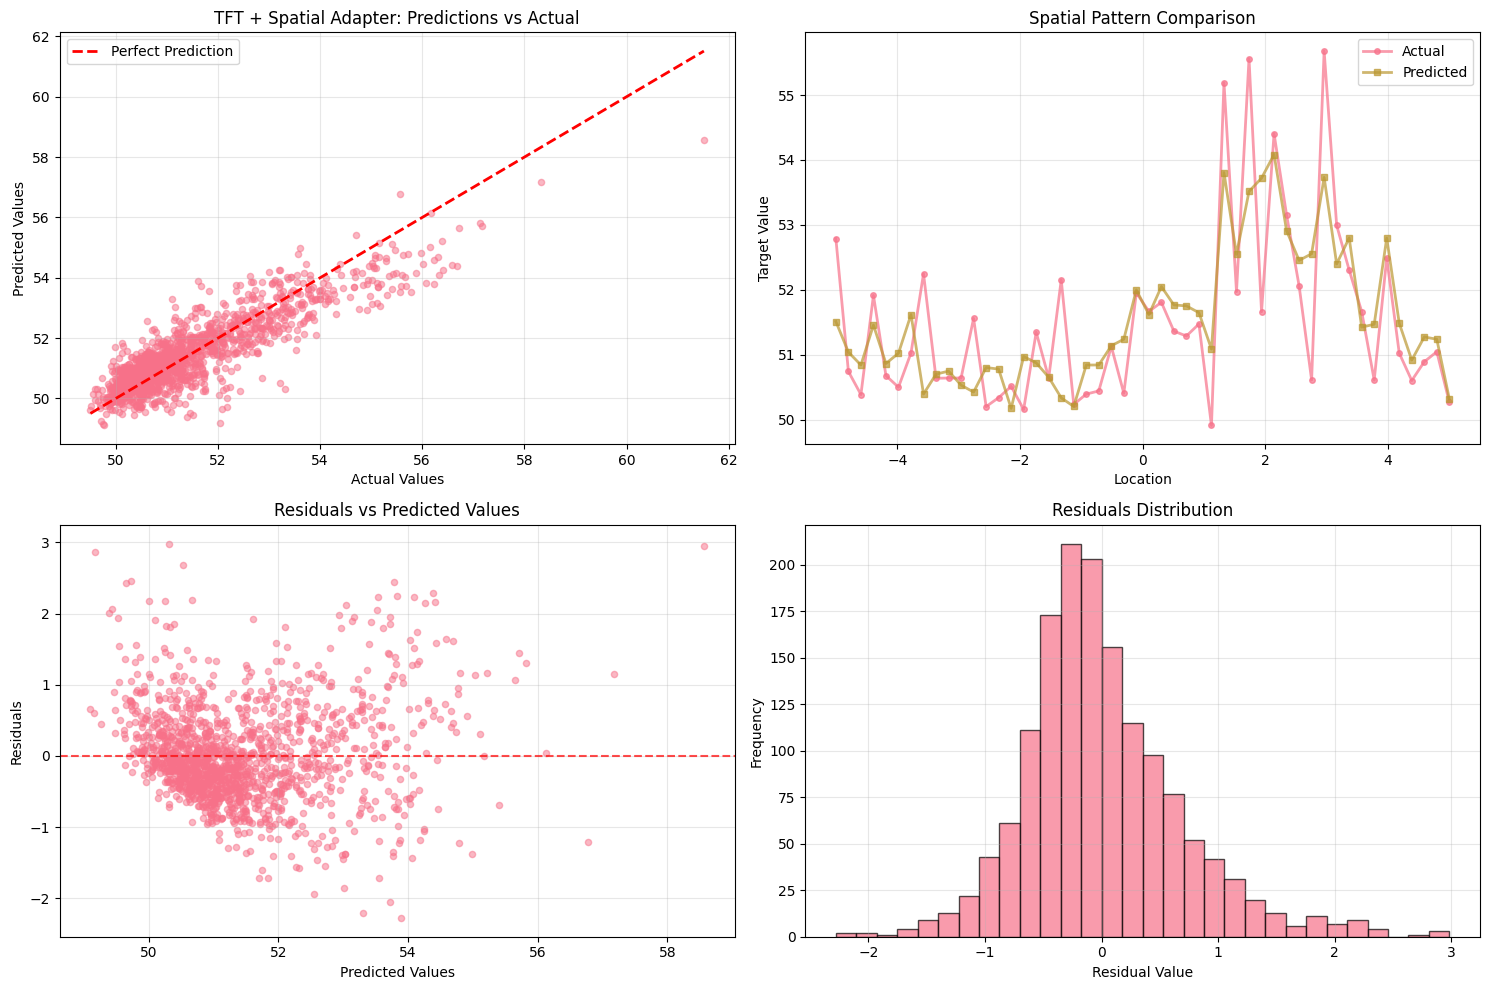

In [11]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Use denormalized data for visualization
val_y_np = val_targets_denorm
y_pred_np = y_pred_denorm

# Plot 1: Predictions vs Actual scatter plot
axes[0, 0].scatter(val_y_np.flatten(), y_pred_np.flatten(), alpha=0.5, s=20)
axes[0, 0].plot([val_y_np.min(), val_y_np.max()], 
                [val_y_np.min(), val_y_np.max()], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_title('TFT + Spatial Adapter: Predictions vs Actual')
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Spatial pattern comparison
sample_idx = 0
axes[0, 1].plot(locations, val_y_np[sample_idx], 'o-', label='Actual', alpha=0.7, linewidth=2, markersize=4)
axes[0, 1].plot(locations, y_pred_np[sample_idx], 's-', label='Predicted', alpha=0.7, linewidth=2, markersize=4)
axes[0, 1].set_title('Spatial Pattern Comparison')
axes[0, 1].set_xlabel('Location')
axes[0, 1].set_ylabel('Target Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals analysis
residuals = val_y_np.flatten() - y_pred_np.flatten()
axes[1, 0].scatter(y_pred_np.flatten(), residuals, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Residuals vs Predicted Values')
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals distribution
axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].set_xlabel('Residual Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Spatial Basis Analysis

Analyzing learned spatial basis...
Basis matrix shape: (50, 10)
Basis norm: 3.1623


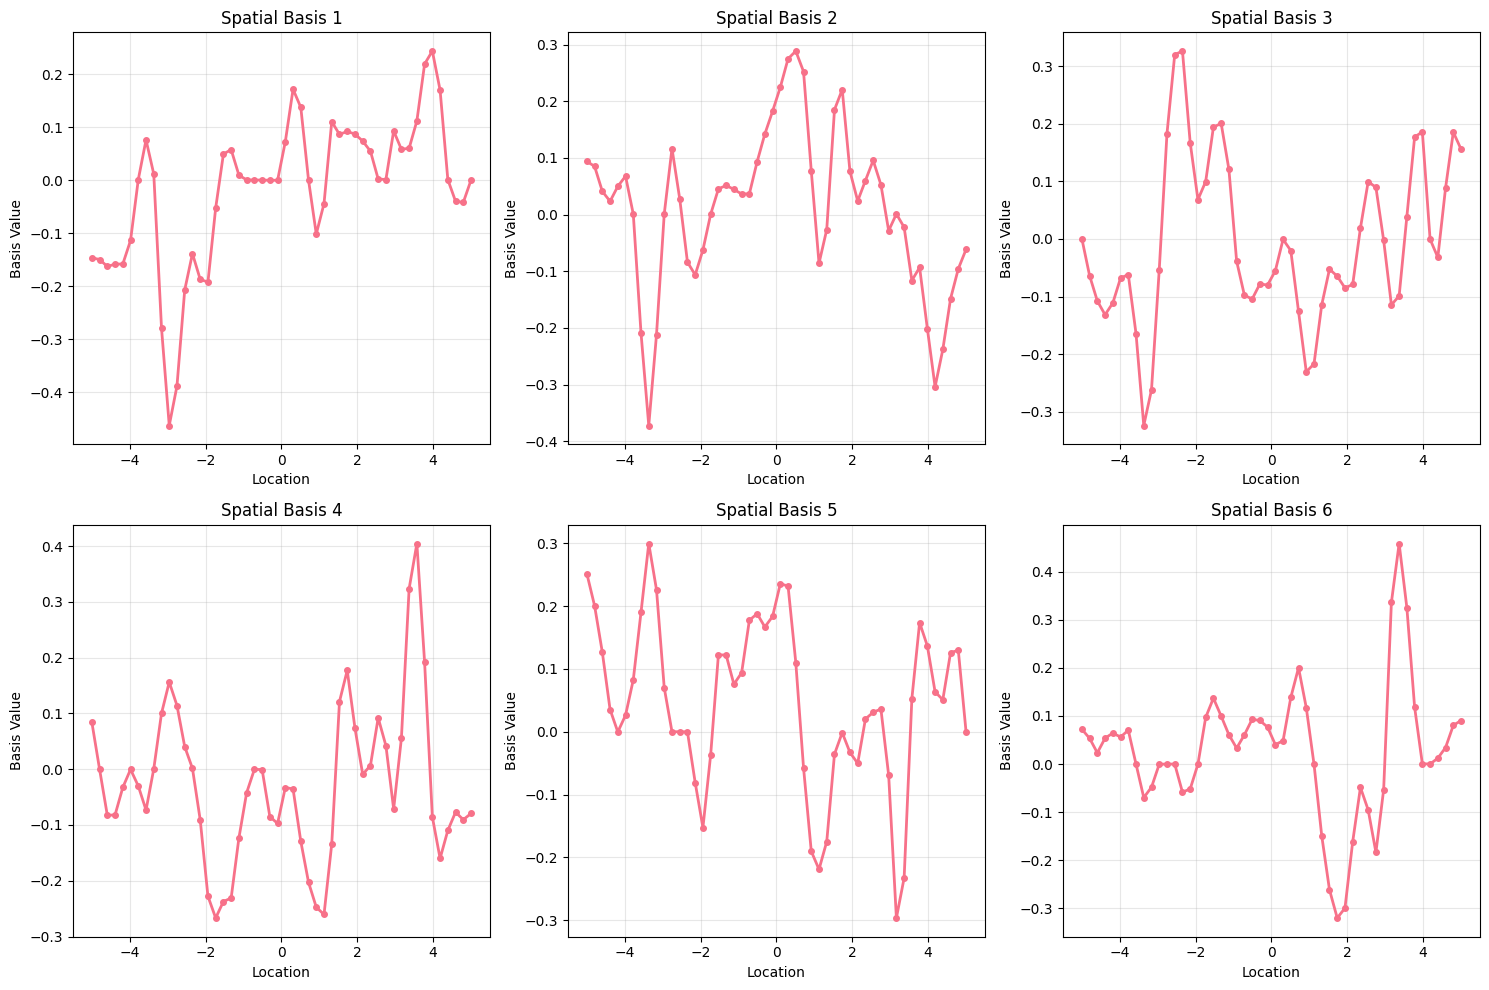


Basis Statistics:
Mean: 0.0142
Std: 0.1407
Min: -0.5367
Max: 0.5212


In [12]:
# Analyze the learned spatial basis
print("Analyzing learned spatial basis...")

# Get the basis matrix
basis_matrix = trainer.basis.basis.detach().cpu().numpy()
print(f"Basis matrix shape: {basis_matrix.shape}")
print(f"Basis norm: {np.linalg.norm(basis_matrix):.4f}")

# Visualize the basis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, basis_matrix.shape[1])):
    # Plot basis vector as spatial pattern
    axes[i].plot(locations, basis_matrix[:, i], 'o-', linewidth=2, markersize=4)
    axes[i].set_title(f'Spatial Basis {i+1}')
    axes[i].set_xlabel('Location')
    axes[i].set_ylabel('Basis Value')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basis statistics
print("\nBasis Statistics:")
print(f"Mean: {basis_matrix.mean():.4f}")
print(f"Std: {basis_matrix.std():.4f}")
print(f"Min: {basis_matrix.min():.4f}")
print(f"Max: {basis_matrix.max():.4f}")

## 10. Performance Summary

In [13]:
# Print final summary
print("=" * 60)
print("TFT + SPATIAL ADAPTER INTEGRATION SUMMARY")
print("=" * 60)
print(f"Device: {device}")
print(f"TFT training time: {tft_training_time:.2f}s")
print(f"Spatial adapter training time: {training_time:.2f}s")
print(f"Total training time: {tft_training_time + training_time:.2f}s")
print()
print("MODEL PARAMETERS:")
print(f"TFT model parameters: {sum(p.numel() for p in tft_trend_model.parameters()):,}")
print(f"TFT trainable parameters: {sum(p.numel() for p in tft_trend_model.parameters() if p.requires_grad):,}")
print(f"Spatial adapter parameters: {sum(p.numel() for p in trainer.basis.parameters()):,}")
print(f"Spatial adapter trainable parameters: {sum(p.numel() for p in trainer.basis.parameters() if p.requires_grad):,}")
print()
print("PERFORMANCE:")
print(f"TFT-only RMSE: {tft_rmse_std:.6f}")
print(f"TFT+Spatial RMSE: {rmse_std:.6f}")
print(f"TFT-only MAE: {tft_mae_std:.6f}")
print(f"TFT+Spatial MAE: {mae_std:.6f}")
print(f"TFT-only R²: {tft_r2_std:.6f}")
print(f"TFT+Spatial R²: {r2_std:.6f}")
print()
print("IMPROVEMENTS:")
if tft_rmse_std != np.inf:
    rmse_improvement = (tft_rmse_std - rmse_std) / tft_rmse_std * 100
    r2_improvement = (r2_std - tft_r2_std) * 100
    print(f"RMSE improvement: {rmse_improvement:.2f}%")
    print(f"R² improvement: {r2_improvement:.2f}%")
else:
    print("Could not compute improvements (TFT evaluation failed)")
print()
print("KEY INSIGHTS:")
print("1. TFT provides temporal modeling capabilities")
print("2. Spatial adapter adds spatial structure modeling")
print("3. Combined approach leverages both temporal and spatial patterns")
print("4. Uncertainty quantification available through spatial adapter")
print("5. Dedicated TFTWrapper handles format conversion and interface compatibility")
print()
print("FILES SAVED:")
print(f"TFT model: {tft_model_path}")
print(f"Tensorboard logs: ./logs/tft_spatial_adapter_demo")
print("=" * 60)

print("\n✅ TFT + Spatial Adapter integration completed successfully!")
print("💡 Run 'tensorboard --logdir ./logs/tft_spatial_adapter_demo' to view training progress")

TFT + SPATIAL ADAPTER INTEGRATION SUMMARY
Device: cuda
TFT training time: 35.65s
Spatial adapter training time: 1.55s
Total training time: 37.20s

MODEL PARAMETERS:
TFT model parameters: 6,643
TFT trainable parameters: 6,642
Spatial adapter parameters: 500
Spatial adapter trainable parameters: 500

PERFORMANCE:
TFT-only RMSE: 1.125599
TFT+Spatial RMSE: 0.685421
TFT-only MAE: 0.733940
TFT+Spatial MAE: 0.512070
TFT-only R²: 0.365100
TFT+Spatial R²: 0.165096

IMPROVEMENTS:
RMSE improvement: 39.11%
R² improvement: -20.00%

KEY INSIGHTS:
1. TFT provides temporal modeling capabilities
2. Spatial adapter adds spatial structure modeling
3. Combined approach leverages both temporal and spatial patterns
4. Uncertainty quantification available through spatial adapter
5. Dedicated TFTWrapper handles format conversion and interface compatibility

FILES SAVED:
TFT model: tft_spatial_adapter_model.pth
Tensorboard logs: ./logs/tft_spatial_adapter_demo

✅ TFT + Spatial Adapter integration completed suc